# TSP Using PuLP


In [16]:
import pulp
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
NO_TOWNS = 30
STARTING_TOWN = 0
nr.seed(1)

In [6]:
# function for creating town coordinates
def create_towns(NO_TOWNS):
    """generate random x and y coordinates for each town"""

    towns_x = nr.rand(NO_TOWNS) # x coordinates for NO_TOWNS number of towns
    towns_y = nr.rand(NO_TOWNS) # y coordinates for NO_TOWNS number of towns
    
    return np.array([towns_x, towns_y]).transpose()

towns = create_towns(NO_TOWNS) # generate coordinates for each town


In [7]:
# distances between towns

distances = np.zeros([NO_TOWNS, NO_TOWNS])
for i in range(NO_TOWNS):
    for j in range(NO_TOWNS):
        distance = ((towns[i][0] - towns[j][0])**2 + (towns[i][1] - towns[j][1])**2)**0.5
        distances[i][j] = distance

In [8]:
# define TSP

prob = pulp.LpProblem('TSP', pulp.LpMinimize)


In [9]:
# variables

# possible edges x(i->j)
x = pulp.LpVariable.dicts('x', ((i, j) for i in range(NO_TOWNS) for j in range(NO_TOWNS)), lowBound=0, upBound=1, cat='Binary')
# MTZ defined u variables
u = pulp.LpVariable.dicts('u', (i for i in range(NO_TOWNS)), lowBound=1, upBound=NO_TOWNS+1)

In [10]:
# objective_function

prob += pulp.lpSum(distances[i][j] * x[i, j] for i in range(NO_TOWNS) for j in range(NO_TOWNS))


In [11]:
# set constraints

for i in range(NO_TOWNS):
    prob += x[i, i] == 0 # cant visit itself
    
for i in range(NO_TOWNS):
    prob += pulp.lpSum(x[i, j] for j in range(NO_TOWNS)) == 1 # make sure that only one destination out from town i
    
for j in range(NO_TOWNS):
    prob += pulp.lpSum(x[i, j] for i in range(NO_TOWNS)) == 1 # make sure that each destination only gets one incoming town
    
    
# ensure that the towns are all connected in one path

for i in range(NO_TOWNS):
    for j in range(NO_TOWNS):
        if i != j and i != 0 and j != 0:
            prob += u[i] - u[j] <= NO_TOWNS * (1 - x[i, j]) - 1
            

In [12]:
%%time

status = prob.solve()

CPU times: total: 78.1 ms
Wall time: 2min 8s


In [13]:
pulp.LpStatus[status]

'Optimal'

In [19]:
routes = [(i, j) for i in range(NO_TOWNS) for j in range(NO_TOWNS) if pulp.value(x[i, j]) == 1]

Text(0.5, 1.05, 'PuLP Optimisation\nRunning CPU Time: 78.1ms\nRunning Wall Time: 2min 8s')

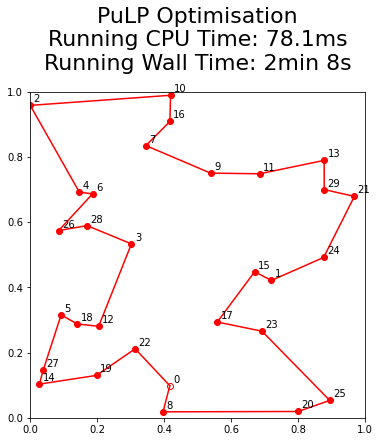

In [64]:
# visualise

plt.figure(figsize=(6, 6))

for i, row in enumerate(towns, 0):
    if i == STARTING_TOWN:
        plt.scatter(row[0], row[1], c='white', edgecolors='red')
    
    else:
        plt.scatter(row[0], row[1], c='red')
        
    plt.text(row[0]+0.01, row[1]+0.01, i)

for edge in routes:
    edge_x = [towns[edge[0]][0], towns[edge[1]][0]]
    edge_y = [towns[edge[0]][1], towns[edge[1]][1]]
    plt.plot(edge_x, edge_y, c='red')
    
plt.xlim([0, 1]); plt.ylim([0, 1])
plt.title('PuLP Optimisation\nRunning CPU Time: 78.1ms\nRunning Wall Time: 2min 8s', y=1.05, fontsize=22)


In [37]:
sum([distances[i][j]*pulp.value(x[i, j]) for i in range(NO_TOWNS) for j in range(NO_TOWNS)])

4.788693446607198

# TSP using vcopt

In [38]:
# import libs

from vcopt import vcopt


In [39]:
towns_x , towns_y = towns.transpose()[0], towns.transpose()[1]

start_town_x = towns_x[STARTING_TOWN]
start_town_y = towns_y[STARTING_TOWN]

path = np.arange(NO_TOWNS) # generate a random initial path that passes through all towns 
path = np.delete(path, np.where(path==STARTING_TOWN)) # remove the starting town from the path

In [40]:
# create scoring function for current path

def score_func(path):
    
    current_towns_x = towns_x[path][:-1]
    current_towns_y = towns_y[path][:-1]
    next_towns_x = towns_x[path][1:]
    next_towns_y = towns_y[path][1:]
    

    # add costs between each non-starting town according to path
    cost = sum(((towns_y[path][1:] - towns_y[path][:-1])**2 + (towns_x[path][1:] - towns_x[path][:-1])**2)**0.5)
    # add cost between first non-starting town and start town
    cost += ((towns_x[path][0] - start_town_x)**2 + (towns_y[path][0] - start_town_y)**2)**0.5 
    # add cost between last non-starting town and start town
    cost += ((towns_x[path][-1] - start_town_x)**2 + (towns_y[path][-1] - start_town_y)**2)**0.5
    
    return cost

In [41]:
# def plotting function for visualising paths at every step of optimisation


def tsp_show_pool(pool, **info):
    """function for visualising path at each generation"""
    # access the info dictionary provided by tspGA() function to get metrics

    
    gen = info['gen']
    best_index = info['best_index']
    best_score = info['best_score']
    mean_score = info['mean_score']
    mean_gap = info['mean_gap']
    time = info['time']
    
    
    plt.figure(figsize=(6, 6))
    
    # visualise some of the paths in each generation's population
    for para in pool[:10]:
        plt.plot(towns_x[para], towns_y[para], 'ok-', alpha=0.1)
    
    best_path_of_pool = np.concatenate(([STARTING_TOWN], pool[best_index], [STARTING_TOWN]))
    print(best_path_of_pool)
    plt.plot(towns_x[best_path_of_pool], towns_y[best_path_of_pool], 'or-')
    plt.plot(towns_x[STARTING_TOWN], towns_y[STARTING_TOWN], 'or', markerfacecolor='w') #indicate start position with X
    plt.xlabel('x'); plt.ylabel('y')
    
    for i, xy in enumerate(zip(towns_x, towns_y), 0):
        plt.text(xy[0]+0.01, xy[1]+0.01, s=i)
        
    plt.xlim([0, 1]); plt.ylim([0, 1])
    plt.title('gen={}, best={:.3f} mean={:.3f} time={:.3f}'.format(gen, best_score, mean_score, time))
    plt.show()


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
________________________________________ info ________________________________________
para_range     : n=29
score_func     : <class 'function'>
aim            : ==0.0
show_pool_func : '<function tsp_show_pool at 0x000001674316C8B0>'
seed           : 69
pool_num       : 20
max_gen        : None
core_num       : 1 (*vcopt, vc-grendel)
_______________________________________ start ________________________________________
Scoring first gen 20/20        
Mini 2-opting first gen 20/20        
[ 0 22 12 26 13 24 15  3 18  8 11  4 10 16 27 17  2 29  1 25 20  5 28  7
  9 21 19 14 23  6  0]


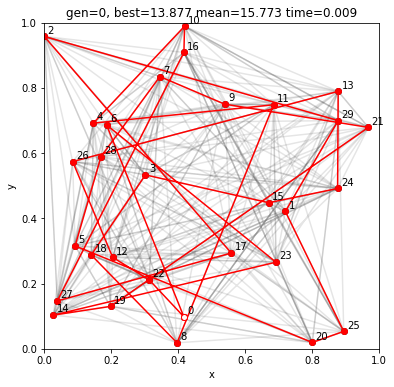

[ 0 28 26  8  6  1  7 12 22  4 16  2 24 27 14 18  5 17 10 21 13 29  9 11
 25 19 20 23  3 15  0]


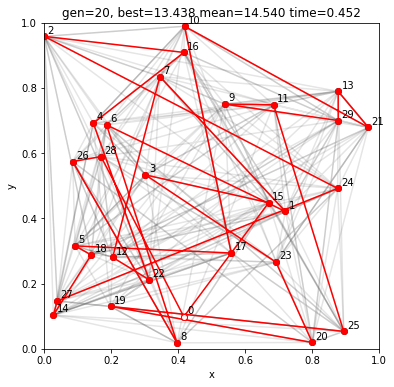

[ 0 28 26  8  6  1  7 12 22  4 16 17  5 18 14 27 24  2 10 21 13 29  9 11
 25 19 20 23  3 15  0]


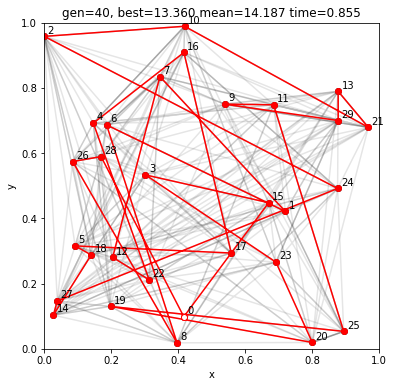

[ 0 23 21  9 12 19 27  2 28 26  6 15 24 18 10 11  7 29 13 20 25 14  8 22
 17 16  1  4  3  5  0]


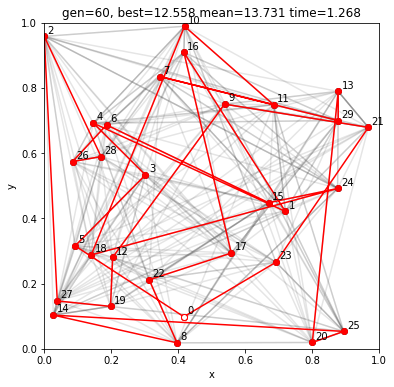

[ 0 23 21  9 12 19 27  5  3  4  1 16 17 22  8 14 25 20 13 29  7 11 10 18
 24 15  6 26 28  2  0]


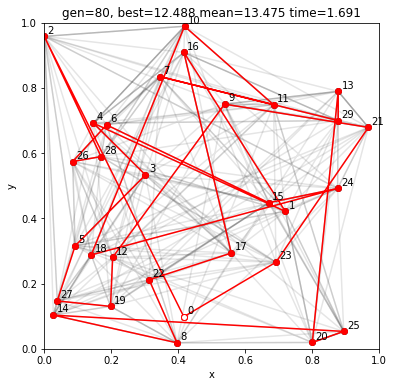

[ 0  1 24 25 20 17 12  5 16 29 23 28  6 10  4  3 11 21  7 26 22 27  2 18
 14  8 19 13  9 15  0]


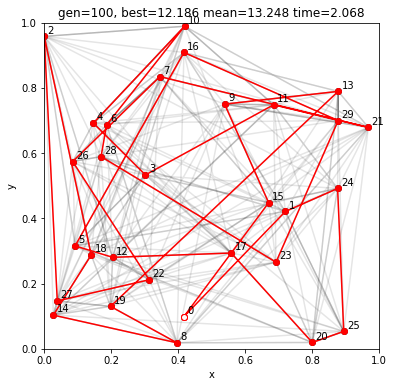

[ 0  1 24 25 20 17 12  5 16 29 23 28  6 10  4  3 11 21 19  8 14 18  2 27
 22 26  7 13  9 15  0]


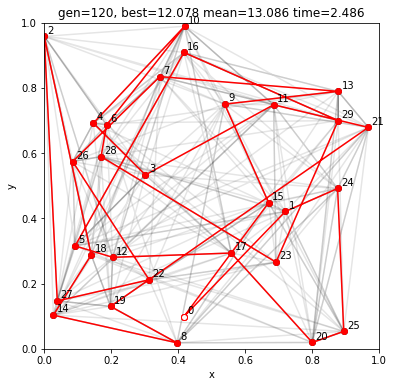

[ 0 28 26  8  6 17  5 18 14 27 24  2 10 21 13 29  9 11 25  1 16  7  4 22
 12 19 15  3 23 20  0]


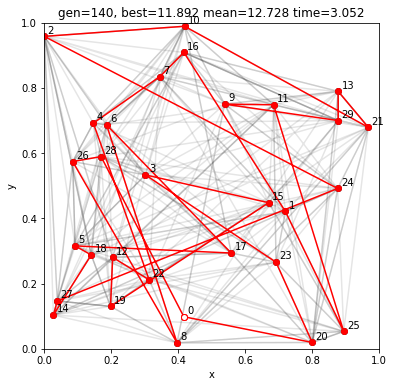

[ 0 23 21  9  4  3  5 27 19 12  1 16 17 22  8 14  2  6 26 28 15 24 11 10
 18  7 29 13 20 25  0]


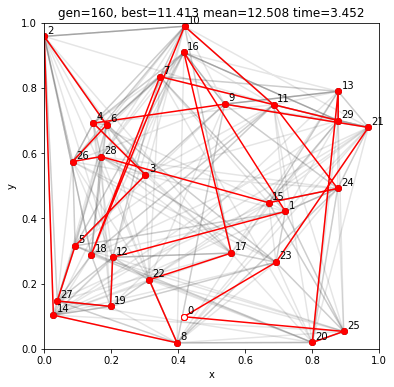

[ 0 23 21  9  4  3  5 27 19 12  1 16 17 22  8 14 28 26  6  2 15 24 11 10
 18  7 29 13 20 25  0]


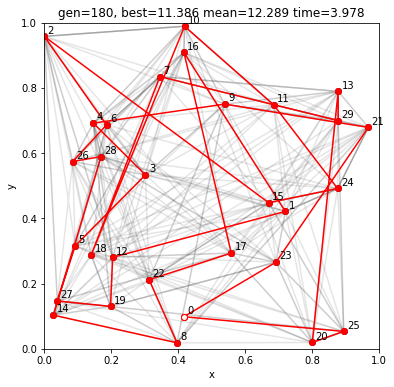

[ 0  1 24 25 20 17 15 23 28  6 10  4  3 11 29  9 13  7 26 22  8 14 18  2
 27 19 21 16  5 12  0]


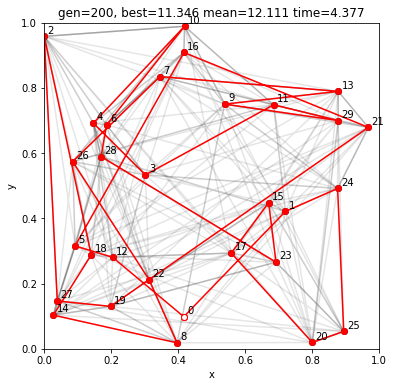

[ 0  1 24 25 20 17 15 23 28  6 10  4  3 19 27  2 18 14  8 22 26  7 13  9
 29 11 21 16  5 12  0]


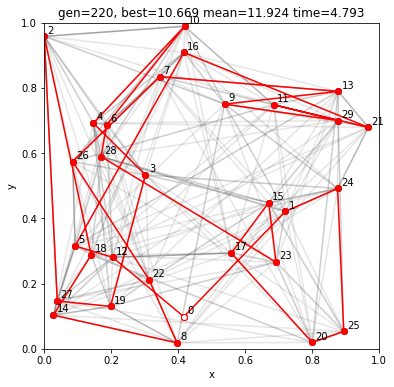

[ 0  1 24 25 20 17 15 23 28  6 10  4  2 27 19  3 18 14  8 22 26  7 13  9
 29 11 21 16  5 12  0]


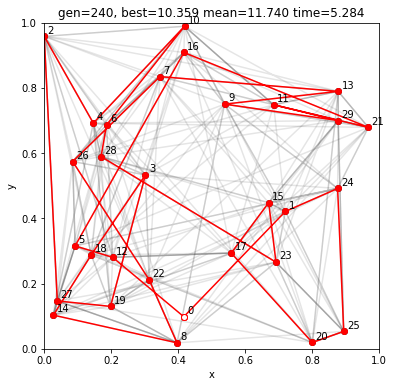

[ 0  1 24 15 17 20 25 23 28  6 10  4  2 27 19  3 18 14  8 22 26  7 13  9
 29 11 21 16  5 12  0]


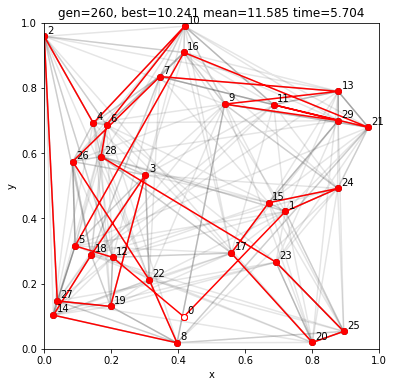

[ 0  1 24 15 17 20 25 23 28  6 21 11 29  9 13  7 26 22  8 14 18  3 19 27
  2  4 10 16  5 12  0]


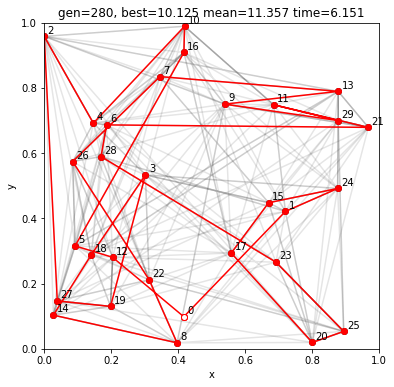

[ 0  1 24 15 17 20 25 23 28  6 21 11 29  9 13  7 26 22  8 14 18  3  5 16
 10  4  2 27 19 12  0]


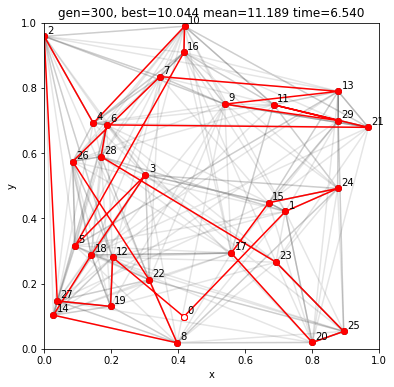

[ 0  1 24 15 17 20 25 23 28  6 26  7 13  9 29 11 21 22  8 14 18  3  5 16
 10  4  2 27 19 12  0]


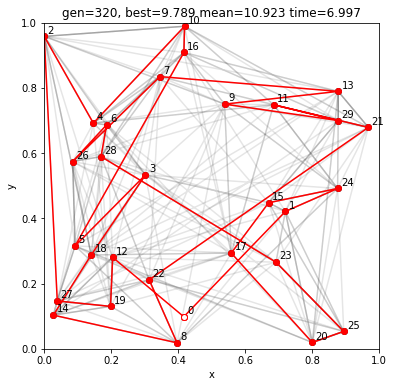

[ 0  1 24 15 17 20 25 23 28  6 26  7 13  9 11 29 21 22  8 14 18  3  5 16
 10  4  2 27 19 12  0]


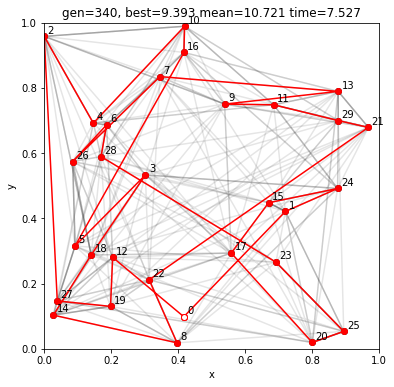

[ 0  1 24 15 17 20 25 23 28  6 26  7 16  5  3 18 14  8 22 21 29 11  9 13
 10  4  2 27 19 12  0]


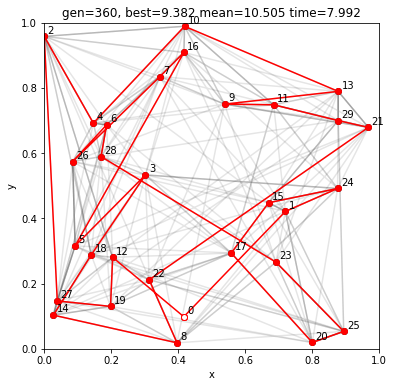

[ 0  1 22  8 14 18  3  5 16  7 26  6 28 23 25 20 17 15 24 21 29 11  9 13
 10  4  2 27 19 12  0]


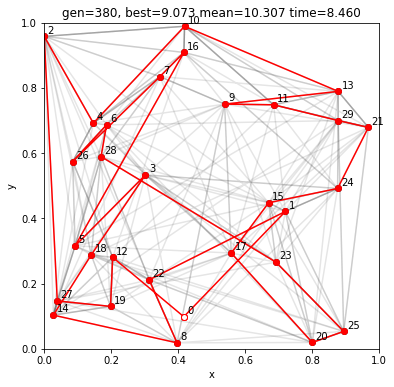

[ 0  1 22 28  6 26  7 16  5  3 18 14  8 23 25 20 17 15 24 21 29 11  9 13
 10  4  2 27 19 12  0]


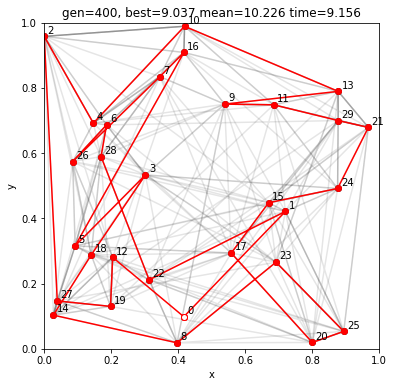

[ 0  1 22 28  6 26  7 16  5  3 18 14  8 23 25 20 17 15 24 21 29 11  9 13
 10  4  2 27 12 19  0]


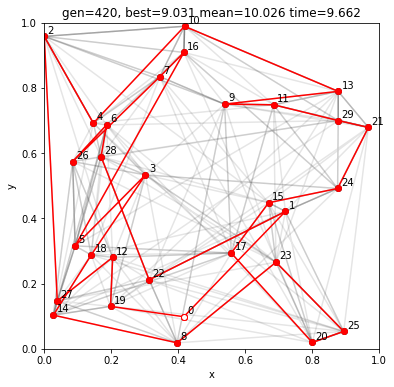

[ 0  1 22 28  6 26  7 16  5  3 18 14  8 23 25 20 17 15 24 21 29  9 11 13
 10  4  2 27 12 19  0]


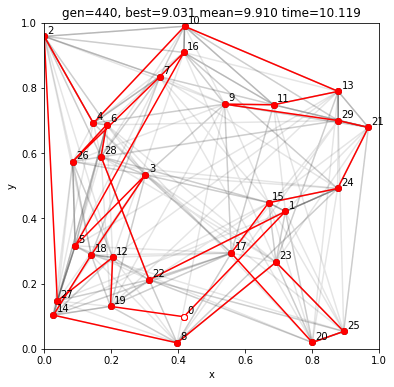

[ 0  8 21 24 16  3  2 28  4  6  7  9 10 29 13 11 18 26  5  1 15 17 20 25
 23 12 27 14 19 22  0]


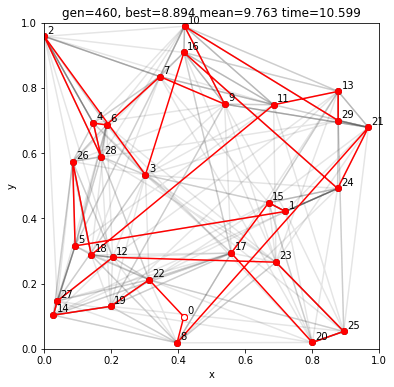

[ 0  8 21 24 16  3  2 28  4  6  7 10  9 29 13 11 18 26  5  1 15 17 20 25
 23 12 27 14 19 22  0]


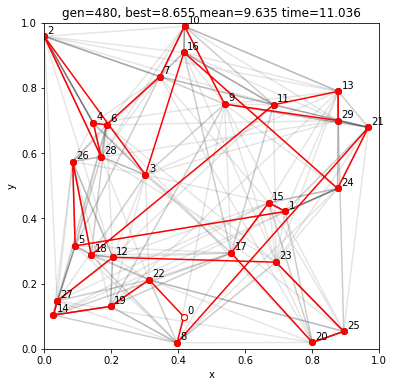

[ 0 23  9 21 29 25 20 27  2  4 26 12 18 22  3 15  1 24 13 11  7 16 10  6
 28  5 14 19  8 17  0]


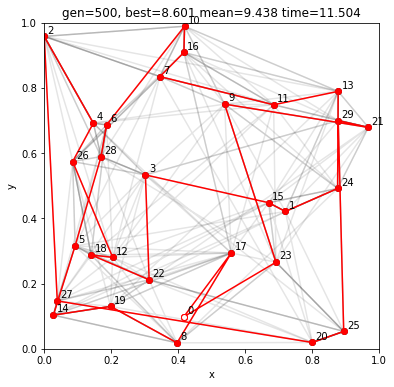

[ 0 28 22 12  8 17 27 14  5 19 18 26  4  7 10 29 21 13 11  9  1 24 16  2
  6  3 15 23 25 20  0]


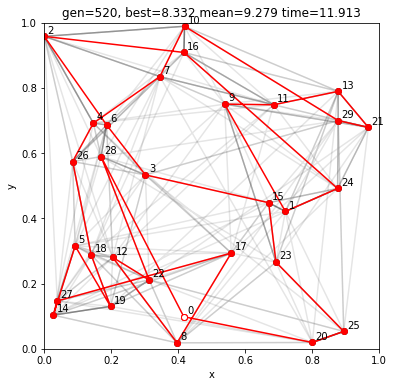

[ 0 28 22 19  5 14 27 17  8 12 18 26  4  7 10 29 21 13 11  9  1 24 16  2
  6  3 15 23 25 20  0]


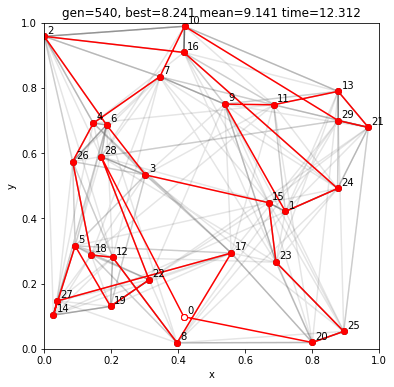

[ 0  1 22  5  3 16  7 26  6 28 12 27 14 18 19  2  4 10 13 11  9 29 21 24
 15 17 20 25 23  8  0]


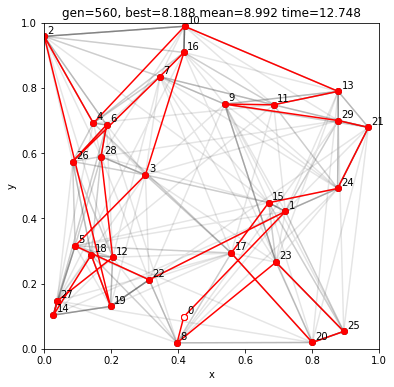

[ 0 23 21  9  4  6 28  2  7 10 16 11 13 29  3 27  5 26 18 12 22 20 25 24
  1 15 17 19 14  8  0]


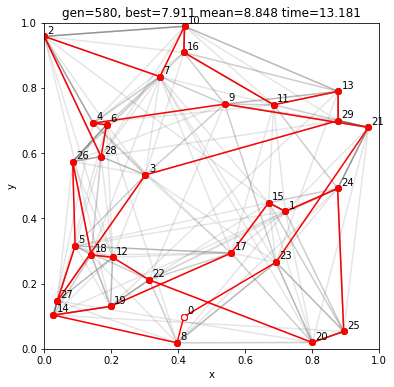

[ 0 23 21  9  4  6 28  2  7 10 16 11 13 29 15  1 24 25 20 22 12 18 26  5
 27  3 17 19 14  8  0]


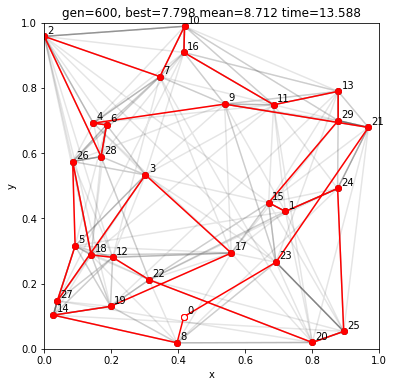

[ 0 23 21  9  4  6 28  2  7 10 16 11 13 29 24  1 15 25 20 22 12 18 26  5
 27  3 17 19 14  8  0]


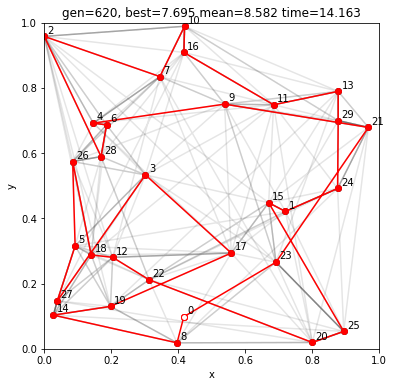

[ 0  1 17 15 24 21 29 13 11  9 10 16  3  5 12 27 14 18 19  2  4  7 26  6
 28 22 20 25 23  8  0]


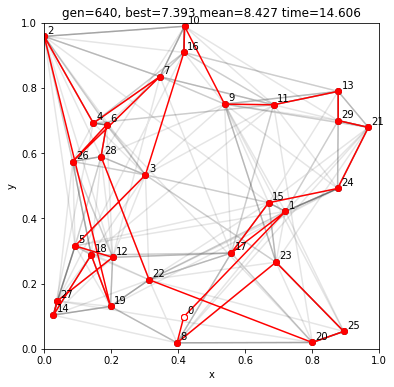

[ 0 22 23 25 20 17 15  1 29 13 11 21 24  9  3  4 16 10  7  6  2 28 12 19
 14 27  5 26 18  8  0]


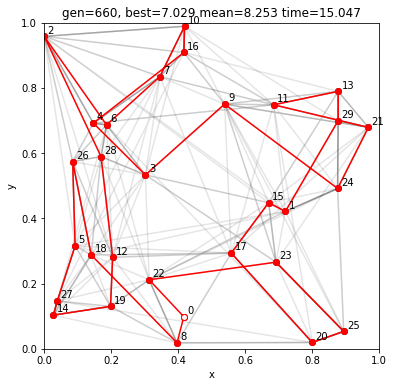

[ 0 22 23 25 20 17 15  1 29 13 11 21 24  9  3  4 16 10  7  6  2 28 18 26
  5 27 14 19 12  8  0]


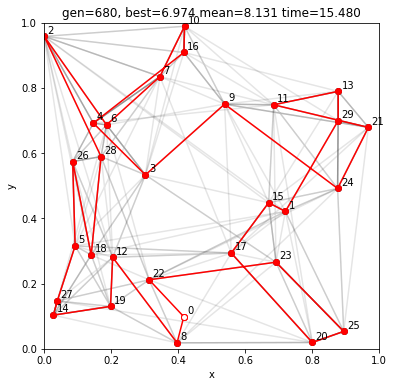

[ 0 22 23 25 20 17 15  1 29 13 11 21 24  9  3  4 16 10  7  2  6 28 18 26
  5 27 14 19 12  8  0]


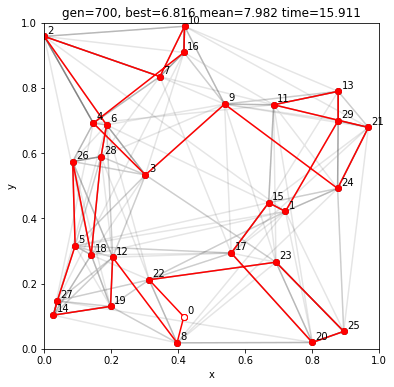

[ 0  1 17 15 24 21 29 13 11  9 10 16  3  5 12 27 14 18 28  6  2  7  4 26
 19 22 23 25 20  8  0]


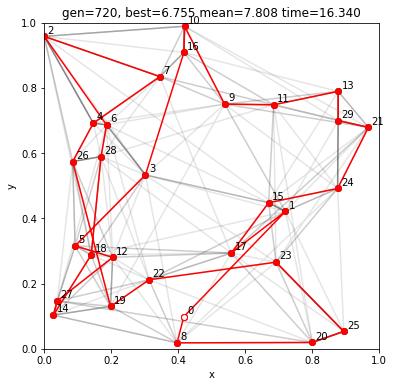

[ 0  1 17 15 24 21 29 13 11  9 10 16  3  5 26  4  7  2  6 28 18 14 27 12
 19 22 23 25 20  8  0]


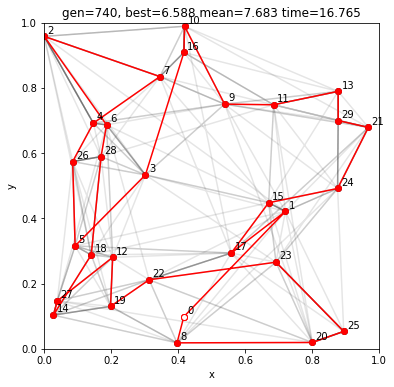

[ 0  1 17 15 24 21 29 13 11  9 10 16  3  5 26  4  2  7  6 28 18 14 27 12
 19 22 23 25 20  8  0]


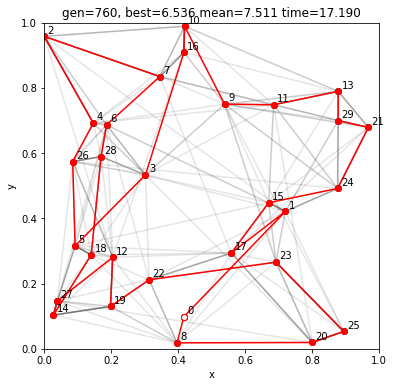

[ 0  1 17 15 24 21 29 13 11  9 10 16  3 28  6  7  2  4 26  5 18 14 27 12
 19 22 23 25 20  8  0]


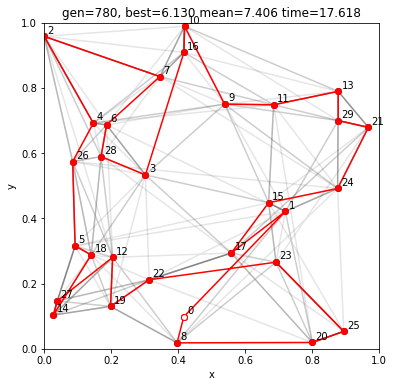

[ 0  1 17 15 24 21 29 13 11  9 10 16  3 28  6  7  2  4 26  5 18 12 27 14
 19 22 23 25 20  8  0]


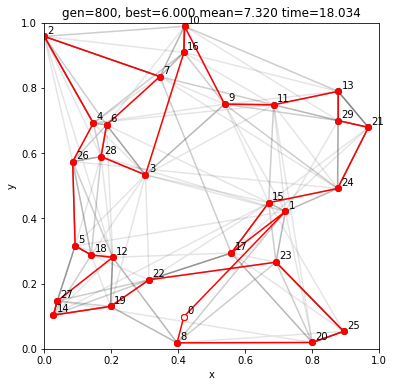

[ 0  1 17 15 24 21 29 13 11  9  7  6 28  3 16 10  2  4 26  5 18 12 27 14
 19 22 23 25 20  8  0]


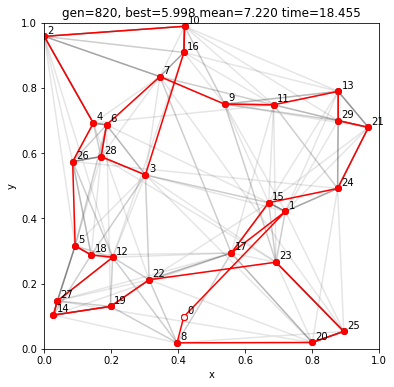

[ 0  1 17 15 24 21 29 13 11  9  7  6 28 26  4  2 10 16  3  5 18 12 27 14
 19 22 23 25 20  8  0]


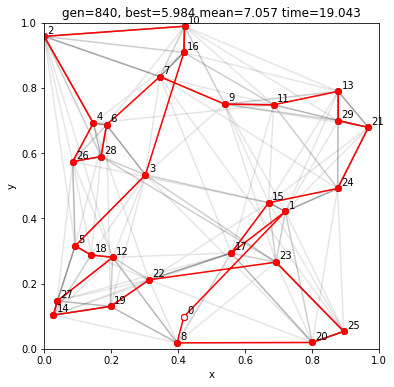

[ 0  1 17 22 19 14 27 12 18  5  3 16 10  2  4 26 28  6  7  9 11 13 29 21
 24 15 23 25 20  8  0]


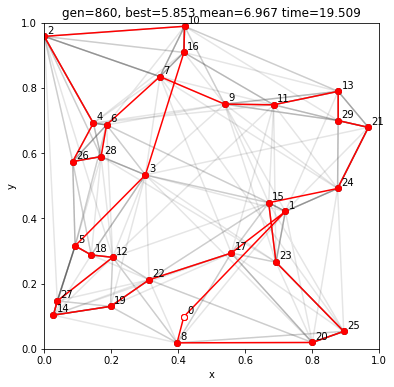

[ 0  1 17 22 19 14 27 12 18  5  3 28 26  4  2 10 16  6  7  9 11 13 29 21
 24 15 23 25 20  8  0]


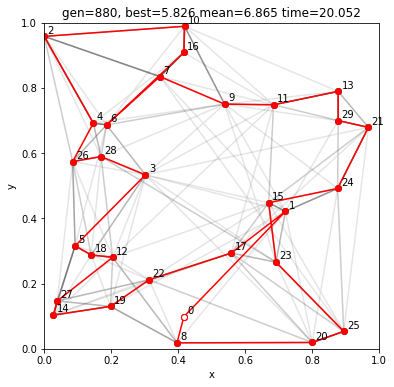

[ 0 23 15 24 21 29 13 11  9  7  6 16 10  2  4 26 28  3  5 18 12 27 14 19
 22 17  1 25 20  8  0]


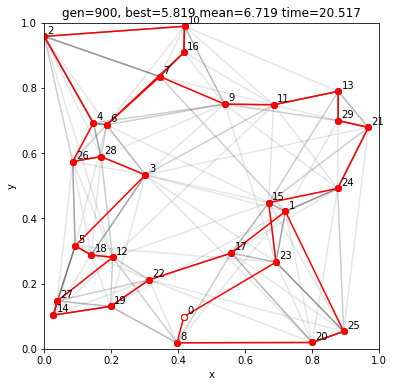

[ 0 23 25 20 17 15  1 24 21 13 29 11  9 16 10  7  2  4  6  3 28 18  5 26
 27 14 19 12 22  8  0]


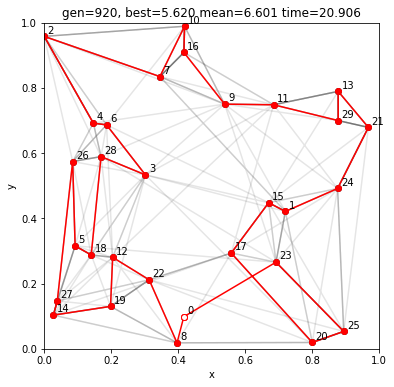

[ 0 17 22 19 14 27 12 18  5  3 28 26  4  2 10 16  6  7  9 11 13 29 21 24
 15  1 23 25 20  8  0]


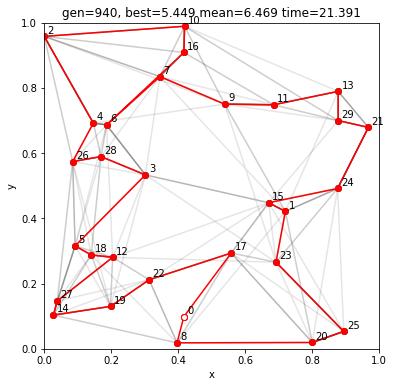

[ 0 17 22 19 14 27 12 18  5  3 28 26  4  2 10 16  6  7  9 11 13 29 21 24
  1 15 23 25 20  8  0]


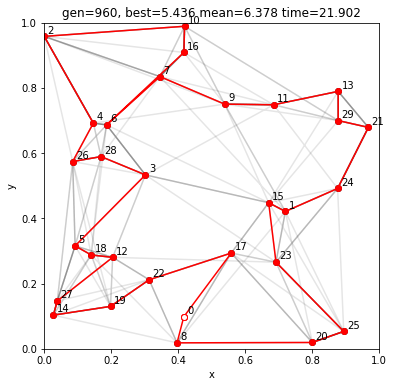

[ 0 17 22 19 14 27 12 18  5  3 28 26  4  2 10 16  7  6  9 11 13 29 21 24
  1 15 23 25 20  8  0]


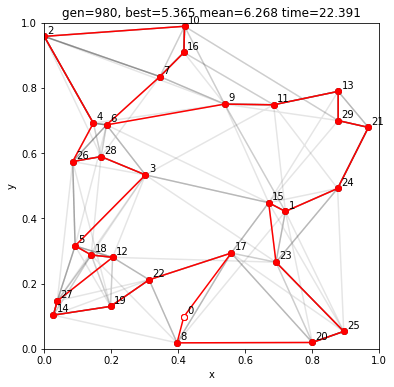

[ 0 17 22 19 14 27  5 18 12  3 28 26  4  2 10 16  7  6  9 11 13 29 21 24
  1 15 23 25 20  8  0]


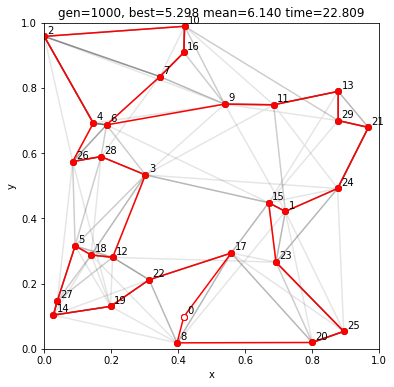

[ 0 17 22 19 14 27  5 18 12  3 28 26  4  2  6  7 16 10  9 11 13 29 21 24
  1 15 23 25 20  8  0]


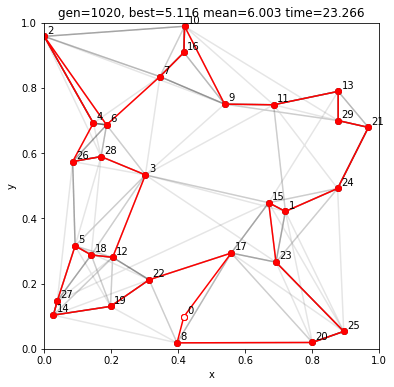

[ 0 20 25 23 17 15  1 24 21 29 13 11  9  7 16 10  2  4  6  3 26 28 18  5
 27 14 19 12 22  8  0]


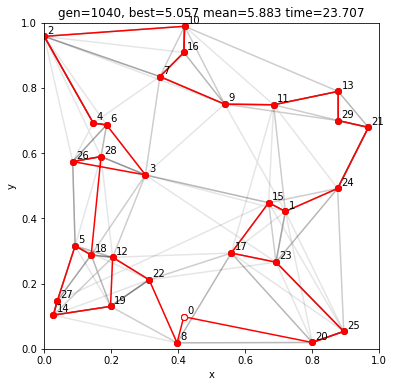

[ 0 20 25 23 17 15  1 24 21 29 13 11  9  7 16 10  2  4  6 28 26  3 18  5
 27 14 19 12 22  8  0]


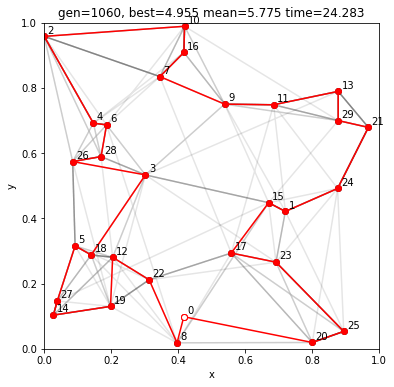

[ 0 20 25 23 17 15  1 24 21 29 13 11  9  7 16 10  2  4  6 26 28  3 18  5
 27 14 19 12 22  8  0]


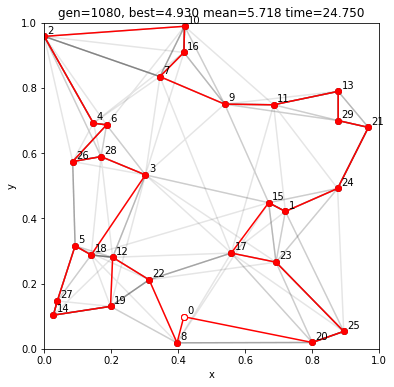

[ 0 22 12 19 14 27  5 18  3 28 26  6  4  2 10 16  7  9 11 13 29 21 24  1
 15 17 23 25 20  8  0]


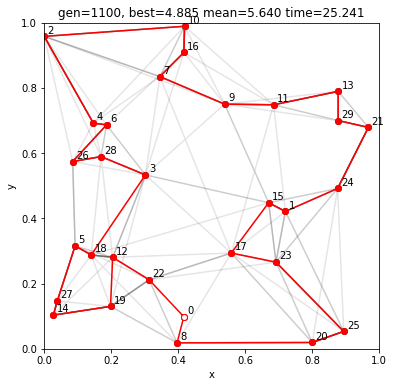

[ 0 22 12 19 14 27  5 18  3 28 26  6  4  2 10 16  7  9 11 13 29 21 24  1
 15 17 23 25 20  8  0]


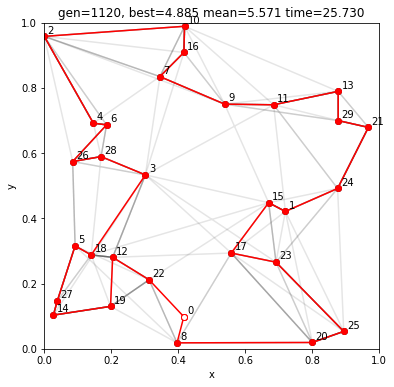

[ 0 22 12 19 14 27  5 18  3 28 26  6  4  2 10 16  7  9 11 13 29 21 24  1
 15 17 23 25 20  8  0]


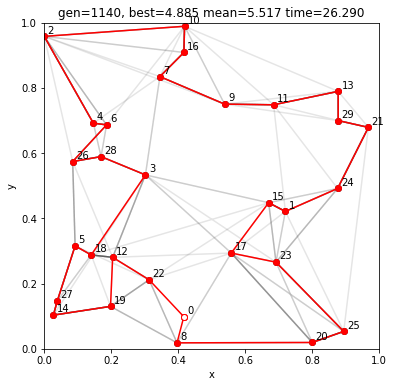

[ 0 22 12 19 14 27  5 18  3 28 26  6  4  2 10 16  7  9 11 13 29 21 24  1
 15 17 23 25 20  8  0]


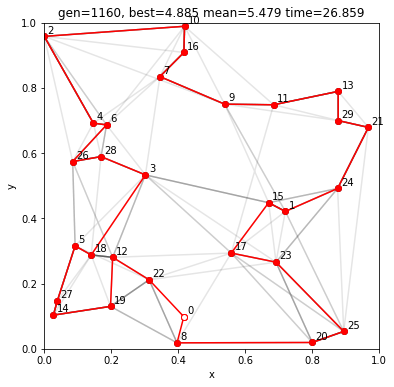

[ 0 22 12 19 14 27  5 18  3 28 26  6  4  2 10 16  7  9 11 13 29 21 24  1
 15 17 23 25 20  8  0]


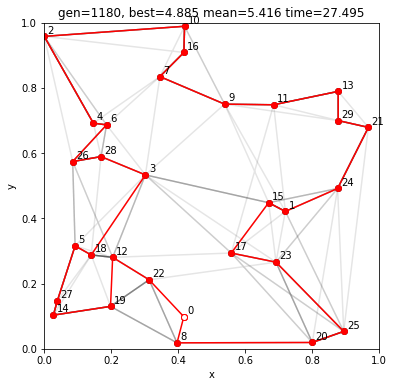

[ 0 22 19 14 27  5 12 18  3 28 26  4  6  2 10 16  7  9 11 13 29 21 24  1
 15 17 23 25 20  8  0]


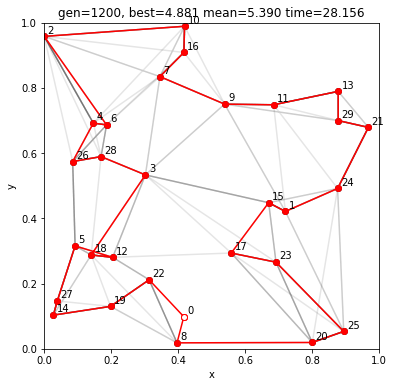

[ 0 22 19 14 27  5 12 18  3 28 26  6  4  2 10 16  7  9 11 13 29 21 24  1
 15 17 23 25 20  8  0]


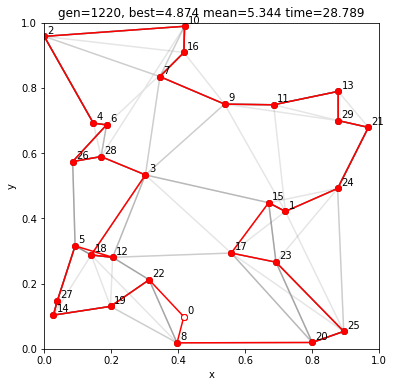

[ 0 22 19 14 27  5 18 12  3 28 26  6  4  2 10 16  7  9 11 13 29 21 24  1
 15 17 23 25 20  8  0]


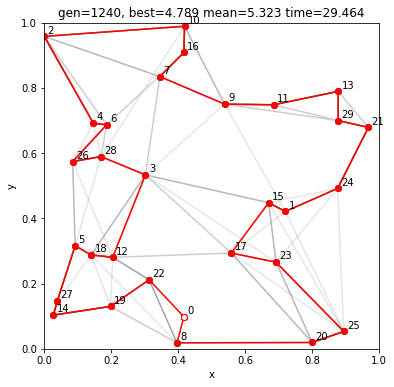

[ 0 22 19 14 27  5 18 12  3 28 26  6  4  2 10 16  7  9 11 13 29 21 24  1
 15 17 23 25 20  8  0]


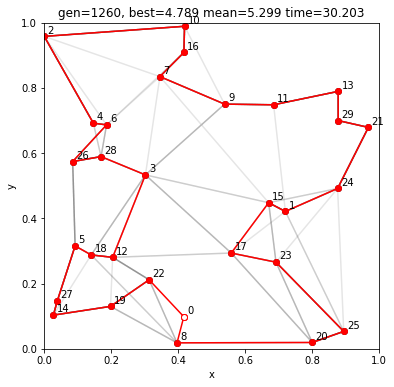

[ 0 22 19 14 27  5 18 12  3 28 26  6  4  2 10 16  7  9 11 13 29 21 24  1
 15 17 23 25 20  8  0]


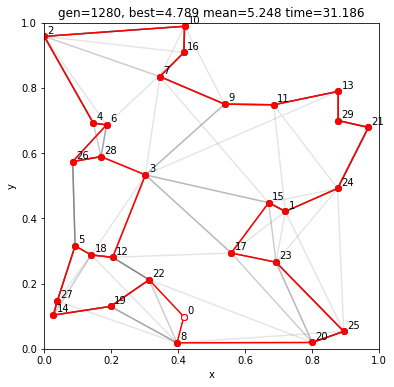

[ 0 22 19 14 27  5 18 12  3 28 26  6  4  2 10 16  7  9 11 13 29 21 24  1
 15 17 23 25 20  8  0]


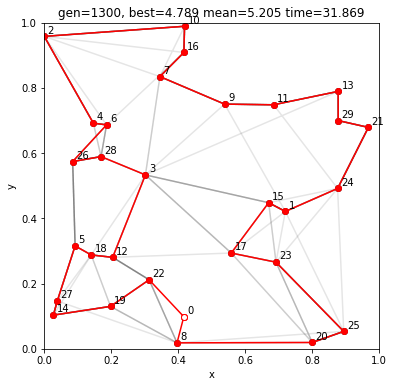

[ 0 22 19 14 27  5 18 12  3 28 26  6  4  2 10 16  7  9 11 13 29 21 24  1
 15 17 23 25 20  8  0]


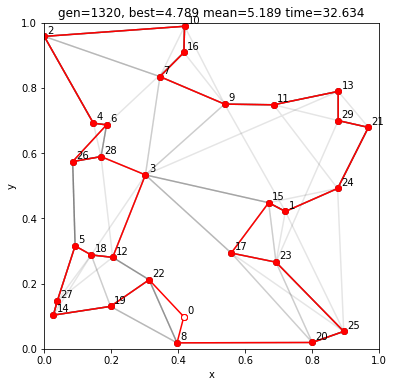

[ 0 22 19 14 27  5 18 12  3 28 26  6  4  2 10 16  7  9 11 13 29 21 24  1
 15 17 23 25 20  8  0]


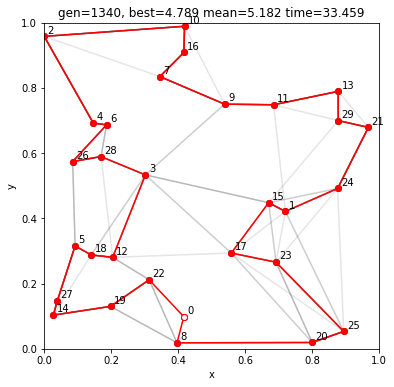

[ 0 22 19 14 27  5 18 12  3 28 26  6  4  2 10 16  7  9 11 13 29 21 24  1
 15 17 23 25 20  8  0]


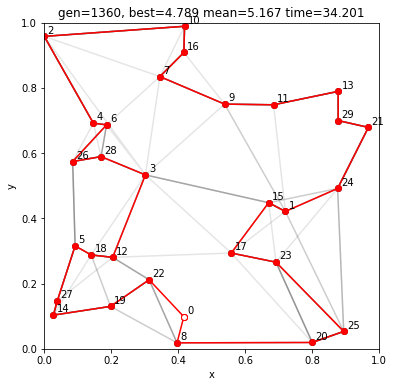

[ 0 22 19 14 27  5 18 12  3 28 26  6  4  2 10 16  7  9 11 13 29 21 24  1
 15 17 23 25 20  8  0]


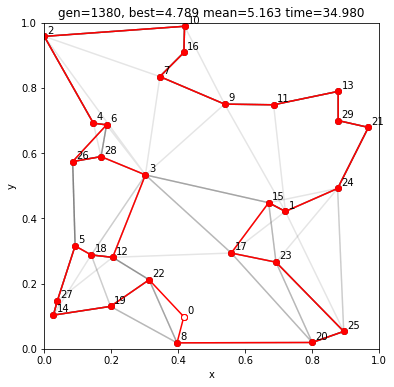

[ 0 22 19 14 27  5 18 12  3 28 26  6  4  2 10 16  7  9 11 13 29 21 24  1
 15 17 23 25 20  8  0]


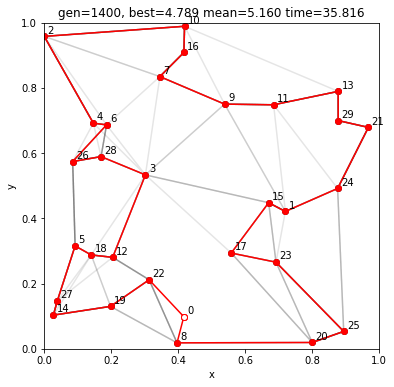

[ 0 22 19 14 27  5 18 12  3 28 26  6  4  2 10 16  7  9 11 13 29 21 24  1
 15 17 23 25 20  8  0]


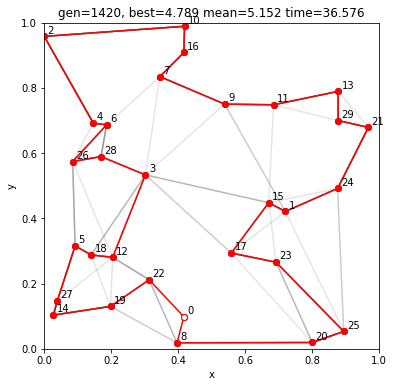

[ 0 22 19 14 27  5 18 12  3 28 26  6  4  2 10 16  7  9 11 13 29 21 24  1
 15 17 23 25 20  8  0]


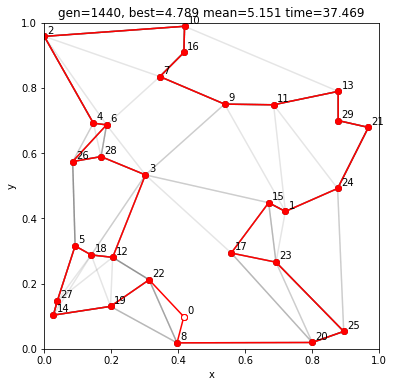

[ 0 22 19 14 27  5 18 12  3 28 26  6  4  2 10 16  7  9 11 13 29 21 24  1
 15 17 23 25 20  8  0]


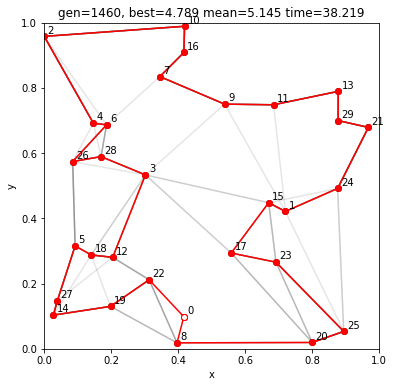

[ 0 22 19 14 27  5 18 12  3 28 26  6  4  2 10 16  7  9 11 13 29 21 24  1
 15 17 23 25 20  8  0]


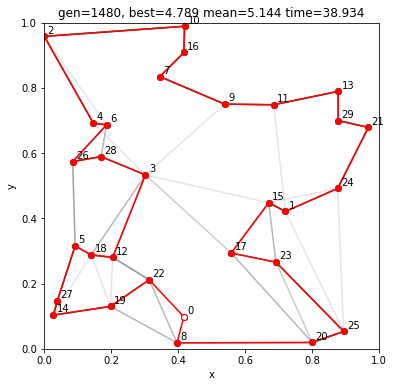

[ 0 22 19 14 27  5 18 12  3 28 26  6  4  2 10 16  7  9 11 13 29 21 24  1
 15 17 23 25 20  8  0]


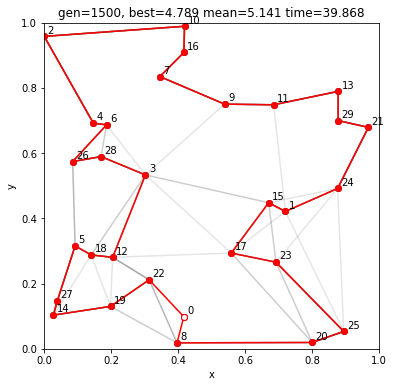

[ 0 22 19 14 27  5 18 12  3 28 26  6  4  2 10 16  7  9 11 13 29 21 24  1
 15 17 23 25 20  8  0]


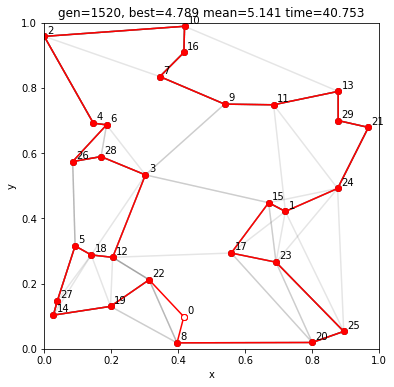

_______________________________________ result _______________________________________
para = np.array([22, 19, 14, 27, 5, 18, 12, 3, 28, 26, 6, 4, 2, 10, 16, 7, 9, 11, 13, 29, 21, 24, 1, 15, 17, 23, 25, 20, 8])
score = 4.788693446607198
________________________________________ end _________________________________________
[22 19 14 27  5 18 12  3 28 26  6  4  2 10 16  7  9 11 13 29 21 24  1 15
 17 23 25 20  8]
4.788693446607198
CPU times: total: 39.4 s
Wall time: 40.9 s


In [42]:
%%time

print(path)

para, score = vcopt().tspGA(path,
                            score_func,
                            0, # we want to minimise our score which measures total distance
                            show_pool_func=tsp_show_pool,
                            pool_num=20,
                            seed=69,
                            ) 

print(para)
print(score)

Text(0.5, 1.05, 'vcopt Optimisation\nRunning CPU Time: 39.4s\nRunning Wall Time: 40.9s')

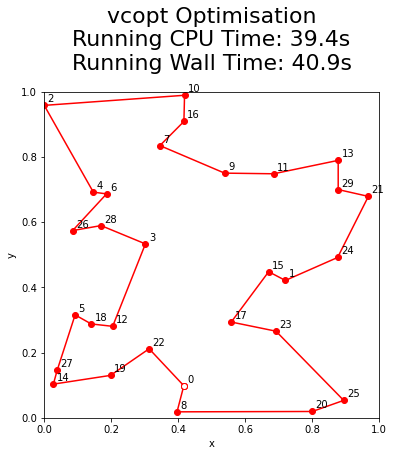

In [62]:
plt.figure(figsize=(6, 6))

best_path = np.concatenate(([STARTING_TOWN], para, [STARTING_TOWN]))

plt.plot(towns_x[best_path], towns_y[best_path], 'or-')
plt.plot(towns_x[STARTING_TOWN], towns_y[STARTING_TOWN], 'or', markerfacecolor='w') #indicate start position with X
plt.xlabel('x'); plt.ylabel('y')

for i, xy in enumerate(zip(towns_x, towns_y), 0):
    plt.text(xy[0]+0.01, xy[1]+0.01, s=i)

plt.xlim([0, 1]); plt.ylim([0, 1])
plt.title('vcopt Optimisation\nRunning CPU Time: 39.4s\nRunning Wall Time: 40.9s', y=1.05, fontsize=22)
